In [1]:
import os
os.environ["OPENAI_API_KEY"] = "sk-"
import openai
openai.api_key = os.getenv("OPENAI_API_KEY")

in_dir = "data\\"
out_dir = "output\\"
os.makedirs(in_dir, exist_ok=True) 
os.makedirs(out_dir, exist_ok=True) 

# Text Analysis on forums from the darkweb, deep web and surface web
To investigate the differences between forums from the DarkWeb and the surface web, we perform the following analysis:

1. Sentiment Analysis: to determine the overall sentiment expressed by users. Comparing sentiment scores between the dark web and surface web can reveal differences in the emotional profile prevalent in each environment. Analyzing sentiment patterns can help in identifying forums with a more negative, secretive, or illicit sentiment, which is typically associated with darknet platforms.

2. Linguistic Analysis: analysing the language used to identify specific linguistic patterns, vocabulary, and expressions unique to each environment. This can help understanding differences in communication styles, jargon, abbreviations or slang used on the dark web versus the surface web.

3. Named Entity Recognition (NER): to extract named entities such as person names, organizations, locations, or specific terms related to illicit activities. By comparing the frequency and context of these entities between the dark web and surface web, it could be possible to gain insights into the types of content and discussions prevalent in each environment.

4. Topic Modeling: we use Latent Dirichlet Allocation (LDA) to identify the main themes or topics discussed in both dark web and surface web forums. By comparing the distribution of topics between the two environments, it could be possible to assess the variations in the types of discussions taking place.

* Other possible analysis for future work:
  - Language Style and Stylometry: investigating the writing style and patterns within forum posts to identify unique linguistic characteristics or stylometric features. By comparing these features between the dark web and surface web, it could be possible to uncover variations in writing styles, vocabulary, or even identify potentially overlapping or connected communities.

  - Network Analysis: performing network analysis on the interactions between forum users, such as co-occurrence analysis, to identify influential users or communities. Contrasting the network structures on the dark web and surface web can reveal differences in the social dynamics and organizational structures within these communities.

In [2]:
# NLP
#conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia
from transformers import RobertaTokenizerFast, TFRobertaForSequenceClassification, pipeline
import gensim
from gensim.utils import simple_preprocess
#!pip install contractions
import contractions
# For tokenization
import nltk
import spacy
#!spacy download en_core_web_lg
nlp = spacy.load("en_core_web_lg")
# Define custom stopwords, lowercase
custom_stopwords = ['i', 'thing', 'post', 'thread', "actually", "use"]
stopwords = nlp.Defaults.stop_words
nlp.Defaults.stop_words |= set(custom_stopwords)
##textblob.download_corpora
#!pip install spacytextblob
from spacytextblob.spacytextblob import SpacyTextBlob
nlp.add_pipe('spacytextblob')
#!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
##!pip install textblob
from textblob import TextBlob

#!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# Data Manipulation
import pandas as pd
pd.set_option("display.precision", 3)
pd.set_option('max_colwidth', 150)
# conda install pyarrow
import re
#!pip install textstat
import textstat
from bs4 import BeautifulSoup

# Data visualisation
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from tqdm.auto import tqdm  # for notebooks
from utils.utils import *

d:\Users\camil\anaconda3\envs\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Users\camil\anaconda3\envs\venv\lib\site-packages\plotly\express\imshow_utils.py:24: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),


## Importing the data
Size of the datasets after cleaning:

| Dataset | Category                         | Original | Duplicates removal | na_removal | % from original |
|---------|---------------------------------|----------|--------------------|------------|-----------------|
| 8kun    | Deep Web (Surface, but not indexed) | 1319     | 1254               | 1253       | 95%             |
| vgr     | Surface Web                     | 38469    | 28138              | 28137      | 73%             |
| 8chan   | Dark Web                        | 3210188  | 38312              | 38312      | 1%              |


In [3]:
# Importing the data
try:
  df_8kun = pd.read_parquet(os.path.join(in_dir, 'df_8kun.parquet'))
  df_8chan = pd.read_parquet(os.path.join(in_dir, 'df_8chan.parquet'))
  df_vgr = pd.read_parquet(os.path.join(in_dir, 'df_vgr.parquet'))
except:
  # Data cleaning: removal of text duplicates, na, websites
  df_8kun = pd.read_csv(in_dir+"forum_8kun.csv", index_col=0).drop(columns={'links', "post_number", "replies_to"}).convert_dtypes()
  df_8kun = df_8kun.drop_duplicates(subset=['text']).dropna(subset=['text']).reset_index(drop=True)
  df_8kun["text"] = df_8kun["text"].apply(lambda x: re.sub(r"https?:\/\/.*[\r\n]*", "", x, flags=re.MULTILINE))
  df_8kun.to_parquet(os.path.join(in_dir, 'df_8kun.parquet'))

  df_8chan = pd.read_csv(in_dir+"forum_dark_web_8chan.csv", index_col=0).drop(columns={"post_number", "replies_to"}).convert_dtypes()
  df_8chan = df_8chan.drop_duplicates(subset=['text']).dropna(subset=['text']).reset_index(drop=True)
  df_8chan["text"] = df_8chan["text"].apply(lambda x: re.sub(r"https?:\/\/.*[\r\n]*", "", x, flags=re.MULTILINE))
  df_8chan.to_parquet(os.path.join(in_dir, 'df_8chan.parquet'))

  df_vgr = pd.read_csv(in_dir+"forum_vgr.csv", index_col=0).convert_dtypes()
  df_vgr = df_vgr.drop_duplicates(subset=['text']).dropna(subset=['text']).reset_index(drop=True)
  df_vgr["text"] = df_vgr["text"].apply(lambda x: re.sub(r"https?:\/\/.*[\r\n]*", "", x, flags=re.MULTILINE))
  df_vgr.to_parquet(os.path.join(in_dir, 'df_vgr.parquet'))

print(f"df_8kun: {df_8kun.shape}\ndf_8chan: {df_8chan.shape}\ndf_vgr: {df_vgr.shape}")

df_8kun: (1253, 3)
df_8chan: (28137, 3)
df_vgr: (38312, 3)


In [4]:
try:
  df_8chan_og = pd.read_csv(in_dir+"forum_dark_web_8chan.csv", index_col=0).drop(columns={"post_number", "replies_to"}).convert_dtypes()
  print("The most repeated entries were:\n")
  display(pd.DataFrame(df_8chan_og["text"].value_counts()).head(25).T)
except:
  print("Only 1% of the original 8chan dataframe remain.")

The most repeated entries were:



,,No,thanks<doc,(checked),I LIKE YOUR ATTITUDE,nice,wew,LOL,Nice,IT'S MISTER LIZARD,...,lmao,Who?,(1),This one?,no,Thank you.,lol,Thanks anon,No.,Thanks doc.
text,5205,1314,1295,957,904,776,731,703,691,684,...,543,527,475,457,455,453,422,404,375,370


## Exploratory data analysis
In the scatterplot we can understand the data better. 
Even though there is more data for the vgr dataset, the total post count and number of unique IDs per thread was highest on 8chan.
This indicates that threads in this forum might be more engaging for its users than the ones from the vgr dataset.
The high engagement of different users per thread is even more impressive considering that the duplicates were removed, as the 8chan dataset is reduced to 1% of its original size.

In general, even the 8kun dataset had more engagement than vgr.
(As the order of magnitude is very different, select on the legend on the right the dataset you can to see)

In [21]:
# Exploratory data analysis
def create_forum_descriptive(df):
  """
  Creating an aggregated DataFrame for analysis from the column 'text'.
  Input: DataFrame with the columns: thread_title, text, poster_id
  Outputs: 
    text: all the discussions for a thread_title
    Unique_ids: Number of unique ids per thread_title
    Total_post_count: Sum of posts per thread_title
  """
  df_desc = df.groupby('thread_title').agg({"text": lambda x: ' '.join(x), 'poster_id': ['nunique', 'count']}).reset_index()
  df_desc.columns = df_desc.columns.map('_'.join)
  df_desc.columns = ['thread_title', 'text', 'Unique_ids', 'Total_post_count']
  df_desc["posts_per_user"] = df_desc["Total_post_count"]/df_desc["Unique_ids"]
  return df_desc

df_8kun_desc = create_forum_descriptive(df_8kun)
df_8chan_desc = create_forum_descriptive(df_8chan)
df_vgr_desc = create_forum_descriptive(df_vgr)

fig = go.Figure()

fig.add_trace(go.Scatter(x=df_8kun_desc['Unique_ids'], y=df_8kun_desc['Total_post_count'], name='8kun',
 mode='markers', #marker=dict(size=df_8kun_desc['len_sum']/100000),
 text=df_8kun_desc['thread_title'], hovertemplate='%{text}<br>%{x} unique ids<br>%{y} total posts'))

fig.add_trace(go.Scatter(x=df_8chan_desc['Unique_ids'], y=df_8chan_desc['Total_post_count'], name='8chan',
 mode='markers', #marker=dict(size=df_8chan_desc['len_sum']/100000),
 text=df_8chan_desc['thread_title'], hovertemplate='%{text}<br>%{x} unique ids<br>%{y} total posts'))

fig.add_trace(go.Scatter(x=df_vgr_desc['Unique_ids'], y=df_vgr_desc['Total_post_count'], name='vgr',
 mode='markers', #marker=dict(size=df_vgr_desc['len_sum']/100000),
 text=df_vgr_desc['thread_title'], hovertemplate='%{text}<br>%{x} unique ids<br>%{y} total posts'))

# Set layout and display the figure
fig.update_layout(title='Exloratory data analysis', xaxis_title='Unique ids', yaxis_title='Total post count')
fig.write_html(os.path.join(out_dir,"Exloratory data analysis.html"))
fig.show()

d:\Users\camil\anaconda3\envs\venv\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

d:\Users\camil\anaconda3\envs\venv\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



### Extra analysis
As 8kun is the smallest dataset some approaches were tested.
* General text analytics with a pairplot to investigate the relashionship between:
  - Total_post_count: total post count
  - words: count of words
  - gunning_fog: Gunning fog index, which is a readability metric used to estimate the years of formal education needed to understand the text. The index is based on two linguistic features: average sentence length and percentage of complex words according to the following formula:
  Gunning Fog Index = 0.4 * ((Total words / Total sentences) + (Percentage of complex words))
  - Unique_ids: How many different users engaged in the thread

  The colours refer to the total post count, as the goal of this analysis was to test whether a popular topic (with many total posts), had a different profile of amount of words, readability or unique ids.

* The [moderation API from OpenAi](https://platform.openai.com/docs/guides/moderation) was not very effective in this studied case. Two different approaches were tested: post per post analysis and for a whole topic. No content was flagged any of the moderated categories: "hate", "hate/threatening", "self-harm", "sexual", "sexual/minors", "violence", "violence/graphic". Scores were very similarly low across the whole dataset. The documentation of the API explicits that it looks for "hateful, harassing, or violent content that:
  - expresses, incites, or promotes hate based on identity
  - intends to harass, threaten, or bully an individual
  - promotes or glorifies violence or celebrates the suffering or humiliation of others

  A hypothesis is that the API only flags things that are extremes in their categories. In special the highest score for hate, albeit barely higher than other samples, was for the post "Remember to keep killing <group of people, redacted>. They are afraid, and they know that they don't have any future.". The example does indeed show hate, but even the second in this category and other categories do not present high scores according to the API.

As both these test did not seem promissing, they were not performed for the other datasets. The motivation was that the API has a limit of 60 requests per minute, making it a very slow process and not worth the results.

d:\Users\camil\anaconda3\envs\venv\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

d:\Users\camil\anaconda3\envs\venv\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

d:\Users\camil\anaconda3\envs\venv\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

d:\Users\camil\anaconda3\envs\venv\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

d:\Users\camil\anaconda3\envs\venv\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

d:\Users\camil\

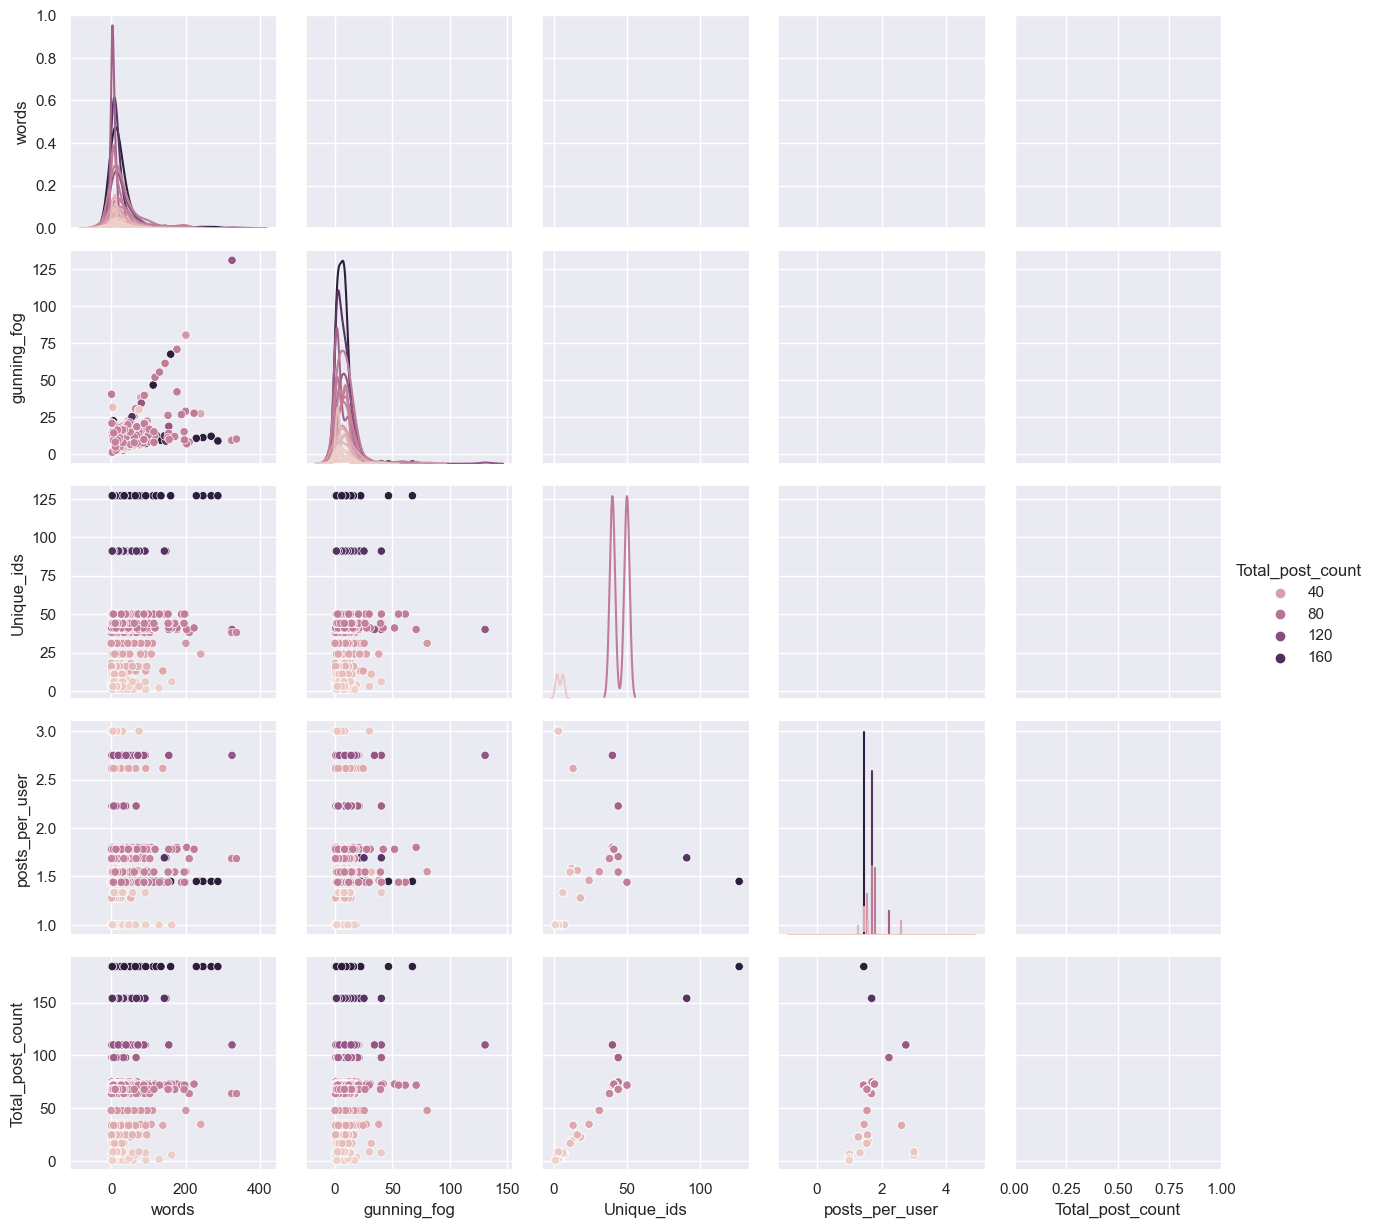

In [6]:
df = pd.merge(df_8kun, df_8kun_desc[['thread_title', 'Unique_ids', 'Total_post_count','posts_per_user']], on=["thread_title"])

# Count words
df['words'] = df['text'].apply(count_words)
# Readability
# df['text_standard'] = df['text'].apply(lambda x: textstat.text_standard(x))
# df['dale_chall_score'] = df['text'].apply(lambda x: textstat.dale_chall_readability_score(x))
df['gunning_fog'] = df['text'].apply(lambda x: textstat.gunning_fog(x)) # School grade able to read, the lower, the easier
#df['flesh_reading_ease'] = df['text'].apply(lambda x: textstat.flesch_reading_ease(x)) #0 - 100, 100 is easier
#df['reading_time'] = df['text'].apply(lambda x: textstat.reading_time(x))

# Count letters
#df['text_len'] = df['text'].str.len()

ax = sns.PairGrid(df, vars=['words', 'gunning_fog', 'Unique_ids', 'posts_per_user', 'Total_post_count'], hue='Total_post_count', diag_sharey=False)
ax.map_lower(sns.scatterplot)
ax.map_diag(sns.kdeplot)
ax.add_legend()

# Save the plot
plt.savefig(os.path.join(out_dir,"pairplot.png"))

In [7]:
# Moderation openai API
try:
  df_8kun_analysis = pd.read_parquet(os.path.join(out_dir, '8kun_analysis.parquet'))
except:
  df_8kun_desc = add_moderation_to_df(df_8kun_desc)
  df_8kun_analysis = add_moderation_to_df(df_8kun)
  df_8kun_analysis.to_parquet(os.path.join(out_dir, '8kun_analysis.parquet'))

df_8kun_analysis.sort_values("hate", ascending=False).head()["text"] #violence, sexual, self-harm, hate/threatening, violence/graphic

888                                                           Remember to keep killing jews. They are afraid, and they know that they don't have any future.
85     Videogames are for straight, white, high IQ, non-lefatrd men only. Everyone else must be kept out, including corporate suits working for the compa...
477                                                                                                                                      <Not better than CJ
956                                                  /v/ got to 25ish users per daynow it's 740/pol/ sitting at 2700 qresearch over 6000Are we being raided?
119                                                                                            Is it normal that I can't see any of the pictures posted itt?
Name: text, dtype: string

# Sentiment Analysis and Named Entity Recognition (NER)
* Vader takes into consideration punctuation, caps, emojis for sentiment analysis, which are very present features in this dataset. Between -1 (negative) and 1 (positive)
* Spacy texblob also shows which tokens were important for its assessment.
* [EmoRoBERTa](https://huggingface.co/arpanghoshal/EmoRoBERTa): from a labelled dataset of 58000 Reddit comments, it classifies text within the 28 emotions: admiration, amusement, anger, annoyance, approval, caring, confusion, curiosity, desire, disappointment, disapproval, disgust, embarrassment, excitement, fear, gratitude, grief, joy, love, nervousness, optimism, pride, realization, relief, remorse, sadness, surprise + neutral

* NER was performed with Spacy

* Others popular libraries for this task: Polyglot, flair, PySentiment, pattern

In [8]:
def get_list_sentiments(doc):
    sent_list = []

    sentiments = doc._.blob.sentiment_assessments.assessments
    for result in sentiments:
        for word in result[0]:
            sent_list.append(word)

    return sent_list

def get_sentiment(text, roberta):
  """
  """
  try:
    return roberta(text)[0]['label']
  except:
    return "Error: Too long text"

In [9]:
# EmoRoBERTa sentiment detection
tokenizer = RobertaTokenizerFast.from_pretrained("arpanghoshal/EmoRoBERTa")
model = TFRobertaForSequenceClassification.from_pretrained("arpanghoshal/EmoRoBERTa")

# Increase the maximum length of tokens
new_max_length = 1024
tokenizer.model_max_length = new_max_length
model.config.max_position_embeddings = new_max_length

roberta = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [10]:
def make_sentiment_analysis(df, source, out_dir = out_dir, vader_model = SentimentIntensityAnalyzer().polarity_scores, nlp = nlp, roberta = roberta, polarity_threshold = 0.25):
  """
  Makes all the sentiment analysis and NER
  """
  # Vader
  tqdm.pandas()
  df["vader"] = df["text"].progress_apply(lambda text: vader_model(text)['compound'])
  # Assign polarity based on the polarity_threshold
  df.loc[df['vader'] > polarity_threshold, 'polarity'] = 'positive'
  df.loc[df['vader'] < -1*polarity_threshold, 'polarity'] = 'negative'
  df['polarity'] = df['polarity'].fillna("neutral")
  # Spacy TextBlob
  df['nlp'] = df['text'].apply(lambda text: nlp(text))
  df['key words'] = df['nlp'].apply(lambda text: ', '.join(get_list_sentiments(text)))
  df['spacy'] = df['nlp'].apply(lambda text: text._.blob.polarity)
  # Named Entity Recognition (NER)
  df['NER'] = df['nlp'].apply(lambda x: [(ent.text, ent.label_) for ent in x.ents])
  df = df.drop(columns = "nlp")
  # Roberta
  tqdm.pandas()
  df["sentiment"] = df["text"].progress_apply(lambda text: get_sentiment(text, roberta))
  # Save
  df = df.convert_dtypes()
  df = df.astype({'polarity': 'category',
                  'vader': 'float32',
                  'spacy': 'float32',  
                  'NER': 'string',                    
                  }, errors='ignore')
  df.to_parquet(os.path.join(out_dir, source+'_analysis.parquet'))
  return df

In [11]:
source = "8kun"
try:
  df_8kun_analysis = pd.read_parquet(os.path.join(out_dir, '8kun_analysis.parquet'))
except:
  df_8kun_analysis = make_sentiment_analysis(df_8kun, source)

# Topic Modelling
* Technique used: Latent Dirichlet Allocation (LDA). This is a bag-of-words (BOW) approach that combines all words into a bag without taking into consideration the deeper semantic understanding or the order of tokens within the document. Thus text cleaning is required. The step taken are in the function "clean_text"  
* Not recommended for very short texts, so it was done per thread. It also requires text cleaning, as it is a
* The results are visualised in [source]_ldavis_[n]: A visualisation of the topic modelling from the LDA and [n] topics
* The most common words, phrases and topics are printed in this section.
* Number of topics chosen was n = 3, since the dataset was extracted from a single topic a higher number might be inadequate.

In [12]:
def clean_text(text, stop_words = nlp.Defaults.stop_words, nlp = nlp, TextBlob = False, contractions = contractions):
    '''
    Return text with the modifications:
    Normalization (lowercase), Removal of unwanted characters and stopwords and lemmatization
    ''' 
    # Tabs
    #text = re.sub(r"[\n][\t]*|[\t]", " ", text) 
    # HTML tags removal
    #text = BeautifulSoup(text, 'html.parser').get_text()
    # Normalization (lowercase)
    text = text.lower()
    # Removing mentions (@person) and Hashtags #topic, 
    #text = re.sub(r"(@|#\ z0-9]+)|([^0-9A-Za-z \t])|^rt", "", text)
    # Links: http://
    #text = re.sub(r"https?:\/\/.*[\r\n]*", "", text, flags=re.MULTILINE) 
    # Contractions
    text = contractions.fix(text)
    # Removal of unwanted characters
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', '', text)
    text = re.sub(r"'", "", text)
    # Numbers
    text = re.sub(r"[0-9]", "",text)
    # too long words: Incomprehensibilities is longest word “in common usage" or single letters
    text = re.sub(r"\b\w{25,90}\b|\b\w{1}\b", "",text)
    
    # Spelling correction
    if TextBlob:
      text = str(TextBlob(text).correct())

    # Lemmatization
    lemmatized = []
     
    doc = nlp(text)
    for token in doc:
        lemmatized.append(token.lemma_)
    
    # Removing Stopwords
    if stop_words:    
        text = " ".join([word for word in lemmatized if word not in (stop_words)])
    text = re.sub(r'\s+',' ',text)
        
    return text.strip()

In [13]:
def make_topic_modelling(df_merged, source, out_dir = out_dir, tokenizer = nltk.word_tokenize, seed = 42, num_words = 15, num_topics = 3):
    """
    """
    # Create Corpus
    df_merged['text_clean'] = df_merged['text'].apply(lambda text: clean_text(text))
    corpus_tokenized = list(df_merged['text_clean'].apply(lambda x: tokenizer(x)))

    # Making ngrams
    ngram, corpus_ngram = make_ngrams(corpus_tokenized)

    dictionary, doc_term_matrix = prepare_corpus(corpus_ngram)
    dictionary.save_as_text(os.path.join(out_dir, source+'_dictionary'))
    print(f"Length of the dictionary: {len(dictionary)}\nMost common words: ")
    print(dictionary.most_common(30))

    frequency = pd.DataFrame.from_dict(ngram.find_phrases(corpus_tokenized), orient='index', columns = ['score']).sort_values(by='score', ascending=False).reset_index()
    display(frequency.head(20).T)

    # Topic modelling
    lda_model = gensim.models.LdaMulticore(doc_term_matrix, num_topics = num_topics, id2word = dictionary,
                                    passes = 20, iterations = 200, chunksize = 2000, eval_every = None, random_state = seed)
    topic_words = lda_model.print_topics(num_topics=num_topics, num_words=num_words)
    for i,topic in enumerate(topic_words):
        print('Topic ' , i , ':', re.findall(r'"(.*?)"', topic[1]))
    return lda_model, doc_term_matrix, dictionary

lda_model, doc_term_matrix, dictionary = make_topic_modelling(df_8kun_desc, "8kun")

# Visualize the topics
num_topics = 3
LDAvis_prepared = gensimvis.prepare(lda_model, doc_term_matrix, dictionary)
pyLDAvis.save_html(LDAvis_prepared, os.path.join(out_dir, source+'_ldavis_'+str(num_topics)+'.html'))
LDAvis_prepared

Length of the dictionary: 325
Most common words: 
[('shit', 101), ('want', 99), ('people', 85), ('fucking', 84), ('I', 83), ('fuck', 82), ('good', 79), ('play', 68), ('know', 66), ('think', 63), ('try', 62), ('time', 59), ('character', 57), ('nigger', 57), ('way', 50), ('site', 49), ('work', 48), ('faggot', 45), ('board', 40), ('dead', 40), ('chan', 40), ('kill', 35), ('add', 34), ('learn', 34), ('level', 34), ('start', 34), ('need', 33), ('find', 31), ('leave', 31), ('look', 31)]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
index,final_fantasy,diversity_commissar,grammar_deck,year_ago,free_speech,year_old,stalker_mod,feel_like,video_game,sound_like,mobile_game,look_like,buy_game,play_game,game_need,people_play,shit_like
score,1.232,1.195,1.179,0.861,0.827,0.818,0.738,0.64,0.636,0.566,0.558,0.539,0.375,0.332,0.321,0.312,0.301


Topic  0 : ['want', 'shit', 'people', 'fucking', 'good', 'fuck', 'play', 'I', 'time', 'site', 'think', 'try', 'know', 'way', 'board']
Topic  1 : ['I', 'add', 'want', 'nigger', 'try', 'sell', 'know', 'learn', 'shit', 'need', 'look', 'friend', 'good', 'people', 'bad']
Topic  2 : ['character', 'fucking', 'shit', 'level', 'nigger', 'woman', 'white', 'faggot', 'fuck', 'man', 'real', 'shitty', 'think', 'win', 'know']


PreparedData(topic_coordinates=           x      y  topics  cluster    Freq
topic                                       
0     -0.045  0.067       1        1  65.576
1     -0.071 -0.058       2        1  24.667
2      0.116 -0.009       3        1   9.756, topic_info=          Term    Freq   Total Category  logprob  loglift
31   character  52.000  52.000  Default   30.000   30.000
80     fucking  79.000  79.000  Default   29.000   29.000
153     nigger  53.000  53.000  Default   28.000   28.000
124      level  31.000  31.000  Default   27.000   27.000
196       shit  96.000  96.000  Default   26.000   26.000
..         ...     ...     ...      ...      ...      ...
219      think   6.911  60.402   Topic3   -4.297    0.159
119       know   5.938  63.015   Topic3   -4.449   -0.035
141       mark   4.201  25.002   Topic3   -4.795    0.544
70        find   4.216  29.774   Topic3   -4.792    0.372
86        good   4.050  76.042   Topic3   -4.832   -0.605

[191 rows x 6 columns], token_table=      Topic   Freq   Term
term                     
1         1  0.629      I
1         2  0.365      I
299       1  0.901     ``
299       2  0.069     ``
5         1  0.094    add
...     ...    ...    ...
236       1  0.708   work
236       2  0.279   work
281       1  0.544  wrong
281       2  0.155  wrong
281       3  0.311  wrong

[320 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

# 8chan

In [14]:
# Sentiment Analysis
source = "8chan"

try:
  df_8chan_analysis = pd.read_parquet(os.path.join(out_dir, source+'_analysis.parquet'))
except:
  df_8chan_analysis = make_sentiment_analysis(df_8chan, source)

In [15]:
# Topic Modelling
lda_model, doc_term_matrix, dictionary = make_topic_modelling(df_8chan_desc, source)

# Visualize the topics
LDAvis_prepared = gensimvis.prepare(lda_model, doc_term_matrix, dictionary)
pyLDAvis.save_html(LDAvis_prepared, os.path.join(out_dir, source+'_ldavis_'+str(num_topics)+'.html'))
LDAvis_prepared

Length of the dictionary: 7950
Most common words: 
[('enemy', 654), ('remake', 645), ('fight', 596), ('weapon', 570), ('pc', 544), ('site', 519), ('sonic', 494), ('switch', 475), ('japanese', 442), ('board', 439), ('ps', 438), ('girl', 437), ('attack', 424), ('able', 416), ('sell', 396), ('company', 390), ('power', 389), ('money', 385), ('image', 384), ('read', 383), ('include', 377), ('life', 373), ('retarded', 366), ('devs', 363), ('map', 363), ('update', 362), ('team', 361), ('example', 353), ('hit', 352), ('dead', 350)]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
index,damsel_distress,los_angeles,argel_tal,lauren_faust,harry_potter,yuji_naka,ray_tracing,mortal_kombat,resident_evil,ion_fury,duke_nukem,mary_skelter,yooka_laylee,baldurs_gate,elden_ring,donkey_kong,etrian_odyssey,deus_ex,jumpy_villager,spurdo_sparde
score,1.425,1.348,1.347,1.347,1.331,1.306,1.267,1.266,1.261,1.25,1.238,1.224,1.224,1.223,1.215,1.209,1.206,1.195,1.192,1.184


Topic  0 : ['sonic', 'site', 'board', 'week', 'movie', 'girl', 'image', 'stream', 'eat', 'life', 'mark', 'friend', 'chan', 'month', 'draw']
Topic  1 : ['pc', 'unit', 'switch', 'capture', 'steam', 'alex', 'list', 'attack', 'linux', 'window', 'recruit', 'file', 'gpu', 'chart', 'console']
Topic  2 : ['remake', 'enemy', 'weapon', 'fight', 'devs', 'japanese', 'gun', 'combat', 'company', 'pc', 'ps', 'title', 'mission', 'mechanic', 'map']


PreparedData(topic_coordinates=           x      y  topics  cluster    Freq
topic                                       
2     -0.046  0.058       1        1  45.241
0     -0.057 -0.054       2        1  36.136
1      0.104 -0.004       3        1  18.623, topic_info=        Term     Freq    Total Category  logprob  loglift
2500  remake  648.000  648.000  Default   30.000   30.000
3328   sonic  474.000  474.000  Default   29.000   29.000
2248    alex  180.000  180.000  Default   28.000   28.000
3441    unit  271.000  271.000  Default   27.000   27.000
3967   linux  181.000  181.000  Default   26.000   26.000
...      ...      ...      ...      ...      ...      ...
1662      ps  138.909  428.235   Topic3   -5.930    0.555
199   option  123.759  329.746   Topic3   -6.046    0.701
1611   power  125.260  375.910   Topic3   -6.034    0.582
983    fight  133.137  582.401   Topic3   -5.973    0.205
257     sell  125.390  386.239   Topic3   -6.032    0.556

[271 rows x 6 columns], token_table=      Topic   Freq    Term
term                      
332       1  0.393    able
332       2  0.374    able
332       3  0.233    able
350       1  0.663  action
350       2  0.279  action
...     ...    ...     ...
2208      2  0.575    word
2208      3  0.053    word
7035      1  0.040      xt
7035      2  0.013      xt
7035      3  0.951      xt

[556 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

# VGR

In [16]:
# Sentiment Analysis
source = "vgr"

try:
  df_vgr_analysis = pd.read_parquet(os.path.join(out_dir, source+'_analysis.parquet'))
except:
  df_vgr_analysis = make_sentiment_analysis(df_vgr, source)

In [17]:
# Topic Modeling
lda_model, doc_term_matrix, dictionary = make_topic_modelling(df_vgr_desc, source)

# Visualize the topics
LDAvis_prepared = gensimvis.prepare(lda_model, doc_term_matrix, dictionary)
pyLDAvis.save_html(LDAvis_prepared, os.path.join(out_dir, source+'_ldavis_'+str(num_topics)+'.html'))
LDAvis_prepared

Length of the dictionary: 10000
Most common words: 
[('want', 5010), ('people', 4964), ('way', 4680), ('come', 4438), ('lot', 4112), ('gaming', 3761), ('try', 3701), ('video_game', 3460), ('look', 3271), ('find', 3153), ('day', 3070), ('love', 3041), ('need', 2977), ('year', 2960), ('character', 2849), ('work', 2657), ('kind', 2650), ('new', 2575), ('start', 2558), ('buy', 2514), ('mean', 2487), ('feel', 2446), ('bad', 2377), ('sure', 2245), ('point', 2188), ('console', 2161), ('ps', 2123), ('long', 2103), ('story', 2093), ('fun', 2091)]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
index,gran_turismo,harry_potter,assassins_creed,mortal_kombat,ghost_tsushima,tomb_raider,elden_ring,donkey_kong,tony_hawk,rick_morty,saint_row,splinter_cell,elder_scroll,prince_persia,duke_nukem,square_enix,ratchet_clank,vice_versa,banjo_kazooie,silent_hill
score,2.128,1.727,1.705,1.605,1.577,1.57,1.558,1.536,1.522,1.485,1.481,1.478,1.477,1.477,1.469,1.458,1.445,1.444,1.432,1.418


Topic  0 : ['year', 'come', 'ps', 'want', 'buy', 'console', 'new', 'love', 'release', 'lot', 'way', 'series', 'look', 'people', 'day']
Topic  1 : ['people', 'character', 'want', 'way', 'video_game', 'lot', 'come', 'look', 'try', 'story', 'feel', 'need', 'kind', 'mean', 'find']
Topic  2 : ['gaming', 'way', 'try', 'find', 'day', 'lot', 'people', 'want', 'need', 'video_game', 'work', 'fun', 'come', 'start', 'hard']


PreparedData(topic_coordinates=           x      y  topics  cluster    Freq
topic                                       
1      0.015 -0.063       1        1  35.427
0     -0.082  0.022       2        1  34.133
2      0.067  0.041       3        1  30.440, topic_info=          Term      Freq     Total Category  logprob  loglift
161         ps  2104.000  2104.000  Default   30.000   30.000
701    console  2141.000  2141.000  Default   29.000   29.000
633    release  1735.000  1735.000  Default   28.000   28.000
328  character  2806.000  2806.000  Default   27.000   27.000
209       year  2930.000  2930.000  Default   26.000   26.000
..         ...       ...       ...      ...      ...      ...
116       look   840.408  3230.543   Topic3   -5.574   -0.157
5        enjoy   670.295  1885.190   Topic3   -5.801    0.155
120       love   722.284  3006.827   Topic3   -5.726   -0.237
634   remember   662.181  1990.412   Topic3   -5.813    0.089
152      point   660.244  2160.530   Topic3   -5.816    0.004

[312 rows x 6 columns], token_table=      Topic   Freq             Term
term                               
923       1  0.864      achievement
923       2  0.092      achievement
923       3  0.044      achievement
5205      1  0.984            actor
5205      2  0.008            actor
...     ...    ...              ...
2737      2  0.016  xbox_controller
2737      3  0.981  xbox_controller
209       1  0.140             year
209       2  0.719             year
209       3  0.141             year

[609 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

# Comparison
* 8kun contains the most negative sentiment emotion across the datasets.
* The biggest emotion detected was "neutral" for all datasets. 
The reason for this is that there are many plainily descriptive posts.
In the vgr dataset the most recurrent post was a simple "no".
However, the second detected emotion is different for all three.
For VGR it is "approval", which is also shown by the mainly positive sentiment detected (59.5%).
For 8chan it is "curiosity", represented by some questions for example.
For 8kun it is "anger", again displaying the overal negative sentiment.
* 8kun also contains more swear words even as the top of its dictionary.

In [66]:
# Comparison plot
fig = make_subplots(
    rows=3, cols=3,
    specs=[[{"colspan": 3}, None, None],
           [{"type": "pie"}, {"type": "pie"}, {"type": "pie"}],
           [{"type": "pie"}, {"type": "pie"}, {"type": "pie"}]],    
    subplot_titles=("Exloratory data analysis","darkweb", "deep web","surface web","darkweb", "deep web","surface web"), )

# Exploratory data analysis
fig.add_trace(go.Scatter(x=df_8kun_desc['Unique_ids'], y=df_8kun_desc['Total_post_count'], name='8kun',
 mode='markers', #marker=dict(size=df_8kun_desc['len_sum']/100000),
 text=df_8kun_desc['thread_title'], hovertemplate='%{text}<br>%{x} unique ids<br>%{y} total posts'), row = 1, col = 1)
fig.add_trace(go.Scatter(x=df_8chan_desc['Unique_ids'], y=df_8chan_desc['Total_post_count'], name='8chan',
 mode='markers', #marker=dict(size=df_8chan_desc['len_sum']/100000),
 text=df_8chan_desc['thread_title'], hovertemplate='%{text}<br>%{x} unique ids<br>%{y} total posts'), row = 1, col = 1)
fig.add_trace(go.Scatter(x=df_vgr_desc['Unique_ids'], y=df_vgr_desc['Total_post_count'], name='vgr',
 mode='markers', #marker=dict(size=df_vgr_desc['len_sum']/100000),
 text=df_vgr_desc['thread_title'], hovertemplate='%{text}<br>%{x} unique ids<br>%{y} total posts'), row = 1, col = 1)

fig.update_layout(title='Text Analysis on forums from the darkweb, deep web and surface web', xaxis_title='Unique ids', yaxis_title='Total post count')

# Sentiment Polarity data
sent1 = df_8chan_analysis["polarity"].value_counts().to_frame()\
  .reset_index().rename(columns={"polarity":"8chan", "index":"polarity"})
sent2 = df_8kun_analysis["polarity"].value_counts().to_frame()\
  .reset_index().rename(columns={"polarity":"8kun", "index":"polarity"})
sent3 = df_vgr_analysis["polarity"].value_counts().to_frame()\
  .reset_index().rename(columns={"polarity":"vgr", "index":"polarity"})
sentiment_df = pd.merge(sent1, sent2, on='polarity')
sentiment_df = pd.merge(sentiment_df, sent3, on='polarity').sort_index().sort_values("polarity")
# Sentiment Polarity vis
fig.add_trace(go.Pie(labels=sentiment_df.polarity, textinfo='label+percent', textposition='inside', marker=dict(colors=["tomato", "wheat", "mediumslateblue"]), 
values=sentiment_df["8chan"]), row=2, col=1)
fig.add_trace(go.Pie(labels=sentiment_df.polarity, textinfo='label+percent', textposition='inside', marker=dict(colors=["tomato", "wheat", "mediumslateblue"]), 
values=sentiment_df["8kun"]), row=2, col=2)
fig.add_trace(go.Pie(labels=sentiment_df.polarity, textinfo='label+percent', textposition='inside', marker=dict(colors=["tomato", "wheat", "mediumslateblue"]), 
values=sentiment_df["vgr"]), row=2, col=3)


# Sentiment Detection data
sent1 = df_8chan_analysis["sentiment"].value_counts().to_frame()\
  .reset_index().rename(columns={"sentiment":"8chan", "index":"sentiment"})
sent2 = df_8kun_analysis["sentiment"].value_counts().to_frame()\
  .reset_index().rename(columns={"sentiment":"8kun", "index":"sentiment"})
sent3 = df_vgr_analysis["sentiment"].value_counts().to_frame()\
  .reset_index().rename(columns={"sentiment":"vgr", "index":"sentiment"})
sentiment_df = pd.merge(sent1, sent2, on='sentiment')
sentiment_df = pd.merge(sentiment_df, sent3, on='sentiment')
# Sentiment Detection vis
fig.add_trace(go.Pie(labels=sentiment_df.sentiment[:n], values=sentiment_df["8chan"]), row=3, col=1)
fig.add_trace(go.Pie(labels=sentiment_df.sentiment[:n], values=sentiment_df["8kun"]), row=3, col=2)
fig.add_trace(go.Pie(labels=sentiment_df.sentiment[:n], values=sentiment_df["vgr"]), row=3, col=3)

# Update and save
fig.update_layout(height=1200, width=1400)
fig.write_html(os.path.join(out_dir,"Report.html"))
fig.show()

d:\Users\camil\anaconda3\envs\venv\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

d:\Users\camil\anaconda3\envs\venv\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [67]:
!conda env export > environment.yml